## Visualizing results of the First Edition -  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the books of the **First Edition ** of the Encyclopaedia Britannica. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_first_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_first_edition' -n 16`


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [5]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [6]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [7]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color = 'green')
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')
    plt.savefig('SpaCy1stEdition.png', dpi=300)

### Information about the defoe georesolution query

This query does the following tasks:

- Ingests all the pages from all the books of the first edition
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: HTML string with the name entities detected by spacy for each page
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (e.g. en_core_web_lg)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
  - display_doc:"<div class=\"entities\" style=\"line-height: 2.5; direction: ltr\"\
    >ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent SCIENCES\
    \ and ARTS .... "
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '57.68633318560074'
        - '-4.96890721218449'
  - lang_model: en_core_web_lg
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [8]:
results=read_query_results('georesolution_en_core_web_lg_EB_first_edition')

In [9]:
#display_spacy_entities(results)

In [10]:
df_total= geresolution_dataframe(results)

In [11]:
df_total.head(10)

,Latitude,Longitude,Place,Page
0,56,-4,SCOTLAND,Page9
1,56,-4,Scotland,Page13
2,43.95221,-103.44575,Calmet,Page13
3,36.48847,-79.7667,Eden,Page13
4,18.38078,-65.95739,Carolina,Page13
5,28.75054,-82.5001,Florida,Page13
6,18.16667,-77.25,Jamaica,Page14
7,43.14675,-71.45757,Pembroke,Page14
8,42.26259,-71.80229,Worcester,Page14
9,42.36837,-83.35271,Livonia,Page15


In [12]:
df_total[["Place"]].count()

Place    3917
dtype: int64

In [13]:
df_total.sum()

Latitude     565643.9522136.4884718.3807828.7505418.1666743...
Longitude    -4-4-103.44575-79.7667-65.95739-82.5001-77.25-...
Place        SCOTLANDScotlandCalmetEdenCarolinaFloridaJamai...
Page         Page9Page13Page13Page13Page13Page13Page14Page1...
dtype: object

In [14]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
8.,1,1,1
A,1,1,1
ABERDEEN,2,2,2
ANATOLIA,2,2,2
ANNAPOLIS,2,2,2
ANSPACH,1,1,1
ANTIBES,1,1,1
ANTIOCH,2,2,2
ANTONIO,2,2,2


In [15]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page10,15,15,15
Page11,35,35,35
Page12,45,45,45
Page13,50,50,50
Page14,74,74,74
Page15,71,71,71
Page16,82,82,82
Page17,119,119,119
Page179,36,36,36


In [16]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place  Page
Latitude  Longitude              
-0.22985  -78.52495       1     1
-0.25     -79.13333       2     2
-0.80834  -80.21974       2     2
-1.25     -78.25         10    10
-1.28844  29.6882         1     1
-10       -55             8     8
          -75.25         19    19
-10.3     149.53333       1     1
-12.04318 -77.02824       5     5
-12.05659 -77.11814       2     2
-12.44417 40.36694        1     1
-12.5     18.5            4     4
-13.52264 -71.96734       2     2
-13.78555 167.40565       2     2
-14.60485 -57.65625      23    23
-16.07806 33.45583        1     1
-16.44972 -39.06472       1     1
-17.82772 31.05337        1     1
-17.98333 20.78333        8     8
-18.25    35              1     1
-18.47333 -47.20028       1     1
-2.71024  132.16831       1     1
-20       47              2     2
-22.20726 29.86486        1     1
-22.73333 29.6            1     1
-23.33333 -58             1     1
-25       25.75           2     2
-26.25    28.4            1     1
-26.46605 23.16496        1     1
-27.13595 27.89993        1     1
...                     ...   ...
6.99861   -8.76389        1     1
60        100             6     6
60.10867  -113.64258     13    13
60.68333  17.36667        1     1
61.1433   54.36585        1     1
61.27448  108.02487       1     1
62        10             12    12
          15             20    20
64        26              7     7
64.75     -21.83333       2     2
65        -15             2     2
          -18             1     1
67.75     26.5            1     1
7.166     5.4394          1     1
7.1881    21.09375       57    57
7.60083   -10.96007       1     1
7.67833   46.99444        1     1
8.33051   30.11588        1     1
8.80402   -7.84832        1     1
8.96154   10.136          1     1
9         -80             2     2
          39.5           11    11
9.16667   92.81667        6     6
9.5       2.25            1     1
9.5066    -75.43954       1     1
9.52392   -75.58139       2     2
9.62203   -79.55898       1     1
9.82029   160.86448       2     2
9.8723    -74.31032       1     1
9.93988   76.26022        4     4

[908 rows x 2 columns]

In [17]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     

# removing the first forw
df_max_geolocations=df_filter
#df_filter.drop([0])
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(15)

,Latitude,Longitude,count
250,34.23314,-102.41075,439
843,54.75844,-2.69531,89
708,48.69096,9.14062,87
770,51.50853,-0.12574,85
795,52.16045,-0.70312,71
855,56,-4,71
769,51.5,10.5,69
662,46,2,59
135,22,79,58
133,21.42664,39.82563,57


In [18]:
#place_count, place_name= get_place(df_total, '50.6522111706725', '-3.615645583175173')


In [19]:
#Getting the 15 places (and their frequencies) most mentioned - filtering out some elements
filter_list=['earth', 'musick', 'the moon']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)

1 89 Britain
2 87 Europe
3 85 London
4 71 England
5 71 SCOTLAND
6 69 Germany
7 59 France
8 58 India
9 57 Mecca
10 57 Africa
12 56 Spain
13 48 America
14 48 Italy
16 40 Ireland
17 38 Rome


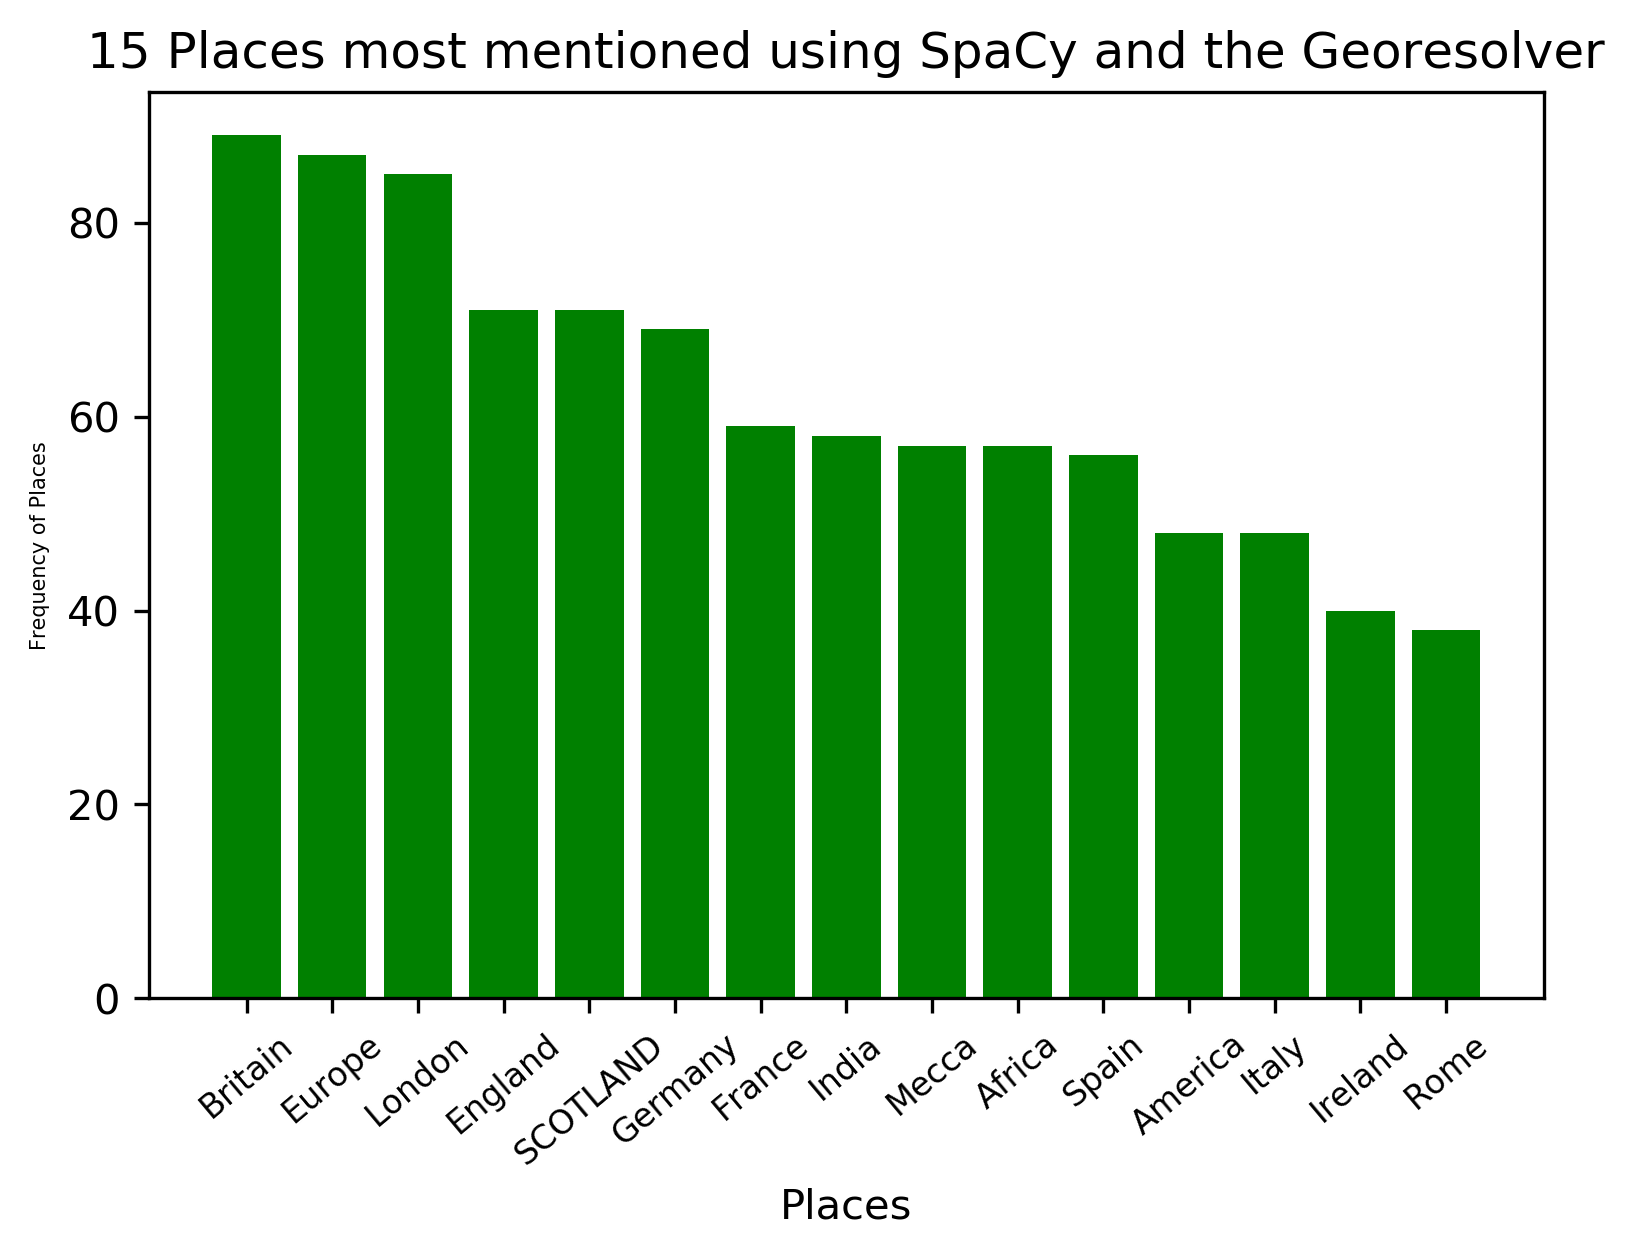

In [20]:
#Visualizing the 15 places in a Bar plot
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq)